In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt

from index_data_handler import IndexDataHandler

# Simulating Returns

In our past analysis we tried to figure out the best portfolio for us. In this analysis we want to see: *What can we expect from a given porfolio?*

Often people look at the mean return per year, lets say 6.5\% and then scale this up by 20 years. While this may give you the mean of the returns it completly ignores the fact that stock returns are highly volatile. It can happen, like in the 70s, that you have a decade of bad performance or like in the 2010s a decade of good performance. This risk should be considered in your analysis.

The next approximation which is often done is to use a normal distribution assumption for the stock returns. While this makes our life as analysts more easy, it may not be a good idea. 

There are two other ways I can come up with which may represent a better way of doing simulation.

The first one is using a bootstrapping technique for the returns. We simply draw a sequence of random past returns and call this a potential future. This allows us to run an arbitrary number of simulations and estimate different worst or best case scenarios.

While this is likely a better approximation of reality than the normal distribution assumption it still lacks an important feature: (auto)Correlation between different months. The worst case scenario for a 10 year period maybe, that we have 120x a 2008-stlye crash. While this is possible to simulate in an uncorrelated world I highly doubt that this is possible. We will explore Marcov-Chain Monte-Calros for a better way of estimating this.

But lets start with: Why a normal distribution is a bad idea.

# The Normal Distribution Flaw



reading cache\990100_END_OF_MONTH_19700101.csv


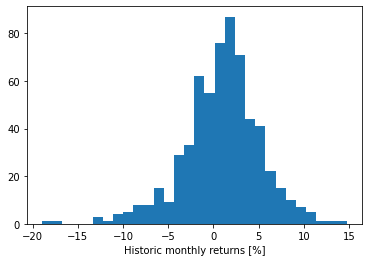

In [2]:
start_date="19700101"
reload=False
reference_index = "MSCI World"

indexHandler = IndexDataHandler(start_date=start_date,frequency="END_OF_MONTH")
index_codes = {**indexHandler.get_available_indices("Developed"), **indexHandler.get_available_indices("US")}
#display(pd.DataFrame.from_dict(index_codes))

df = indexHandler.get_historic_stock_data(index_codes[reference_index]["code"], reload=reload)
df = df.rename(columns={'level_eod':"level"})
df['gain'] = df['level'].pct_change()
df = df.dropna()
plt.xlabel("Historic monthly returns [%]")
plt.hist(df['gain']*100,bins=30)
plt.show()

We can already see from this graph of monthly returns that it does not really look like a normal distribution (bell curve). Especially the lfet hand side tail looks suspicials to me. Lets look at the moments of the distribution and then perform a quick Kolmogorov-Smirnoff test to check for Normal distribution

In [3]:
print(stats.describe(df['gain']))

k2, p =stats.kstest((df['gain']-df['gain'].mean())/df['gain'].std(), 'norm')
print(p)


DescribeResult(nobs=615, minmax=(-0.18934079218009348, 0.14713747807111432), mean=0.008931453966826531, variance=0.0018253809173499674, skewness=-0.5378178053528934, kurtosis=1.6640157967349243)
0.03912824505143164


So the skeweness and the kurtosis are both != 0, which means that its likely not a normal distribution. It basically just measures the tails we can already see in the histogram. Additionally the pvalue of the test supports the argument: **Normal distribution is not a good idea.** But how bad is it?

Anyway, lets move on with our analysis. We will use 20 years of horizon and always 50.000 simulated futures.

In [4]:
n = 100000
investment_horizon = 240 #months
quantile_data = pd.DataFrame()

In [5]:
# main function to visualize results later on
def plot_series_aggregate(df,method_name, quantiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]):
    aux = pd.DataFrame() 
    aux['average'] = df.mean(axis=1)
    results = {}
    
    plt.figure(figsize=(15, 10))
    plt.grid(True)
    plt.xlabel("Month")
    plt.ylabel("Balance")
    for q in quantiles:
        name = str(q)+"% quantile"
        aux[str(q)+"% quantile"] = df.quantile(q,axis=1)
        results[str(q)+"% quantile"] = [aux[str(q)+"% quantile"][investment_horizon-1]]
        plt.plot(aux[str(q)+"% quantile"],label=name)
    aux2 = pd.DataFrame(results,index=[method_name])
    display(aux2)
    plt.legend(prop={'size':24})
    return aux2

# Normal Distribution Simulation
Lets simulate the whole thing using a normal distribution assumption. For now we assume a initial investment of 1$/Euro and we see how it performs

In [6]:
mu = df['gain'].mean()
sigma = df['gain'].std()
print("Mean:",mu, "Standard_deviation: ",sigma)
potential_series = {}
for i in range(0,n):
    rnd = np.random.normal(mu,sigma,investment_horizon)+1
    potential_series[i] = rnd.cumprod()
normal_distribution_returns = pd.DataFrame(potential_series)



Mean: 0.008931453966826531 Standard_deviation:  0.04272447679433848


,0.01% quantile,0.05% quantile,0.25% quantile,0.5% quantile,0.75% quantile,0.95% quantile,0.99% quantile
normal,1.465145,2.3077,4.355997,6.788943,10.598066,19.909857,31.154091


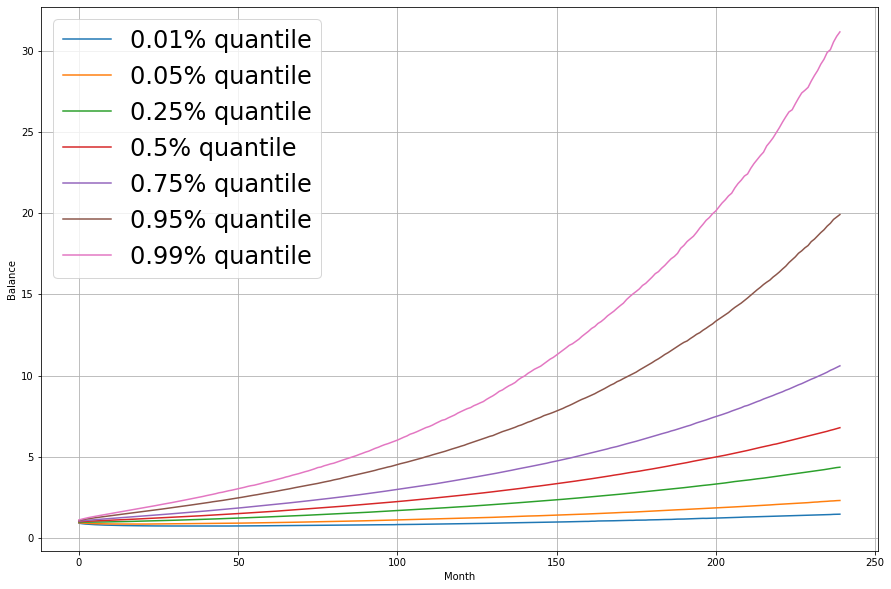

In [7]:
quantile_data=plot_series_aggregate(normal_distribution_returns,method_name="normal")

What can we learn? So in average outcome is that our 1USD becomes 6.77USD. But in 1\% of the cases the 1$ results only in a final portfolio of 1.44USD. This is not even inflation.

# Bootstrapping

In [8]:
potential_series = {}
potential_gains = {}
for i in range(0,n):
    aux = df.sample(investment_horizon,replace=True).reset_index()['gain']+1
    potential_series[i] = aux.cumprod()
    potential_gains[i] = aux-1
bootestrapped_returns = pd.DataFrame(potential_series)
bootstrapped_gains = pd.DataFrame(potential_gains)
#display(df4)

,0.01% quantile,0.05% quantile,0.25% quantile,0.5% quantile,0.75% quantile,0.95% quantile,0.99% quantile
bootstrapped,1.412255,2.2644,4.353604,6.819032,10.663671,20.112854,31.033872


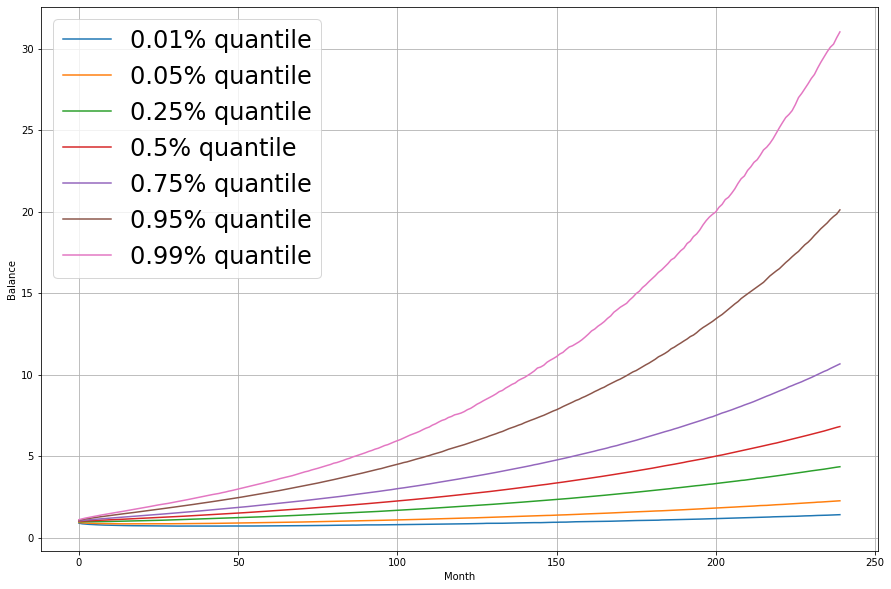

In [9]:
quantile_data = pd.concat([quantile_data,plot_series_aggregate(bootestrapped_returns,'bootstrapped')])

What can we learn? So in average outcome is that our 1USD becomes 6.82USD. But in 1\% of the cases the 1$ results only in a final portfolio of 1.40USD. The mean is slighly higher than the one from the normal distribution and the 1\% quartile is slightly lower


In [10]:
display(quantile_data)

,0.01% quantile,0.05% quantile,0.25% quantile,0.5% quantile,0.75% quantile,0.95% quantile,0.99% quantile
normal,1.465145,2.3077,4.355997,6.788943,10.598066,19.909857,31.154091
bootstrapped,1.412255,2.2644,4.353604,6.819032,10.663671,20.112854,31.033872


# What happens to Saving Plans?
So far we analyzed a 1-time investment of 1Euro. In reality we more have saving plans. Let's simulate what happens if you invest 1 USD per month over the course of our investment horizon.


In [21]:
def calc_savings_plan(x,monthly_rate=1):
    r = []
    current_balance = monthly_rate
    for v in x:
        current_balance = current_balance*(1+v)+monthly_rate
        #print(v, current_balance)
        r.append(current_balance)
    return pd.Series(r)

In [22]:
simulated_saving_plan_dict = {}
for i in range(0,n):
    simulated_saving_plan_dict[i] = calc_savings_plan(bootstrapped_gains[i],monthly_rate=1)
simulated_savings_df = pd.DataFrame(simulated_saving_plan_dict)


,0.01% quantile,0.05% quantile,0.25% quantile,0.5% quantile,0.75% quantile,0.95% quantile,0.99% quantile
bootstrapped savings,262.44541,353.292112,546.625633,748.075893,1029.613488,1649.767867,2315.077931


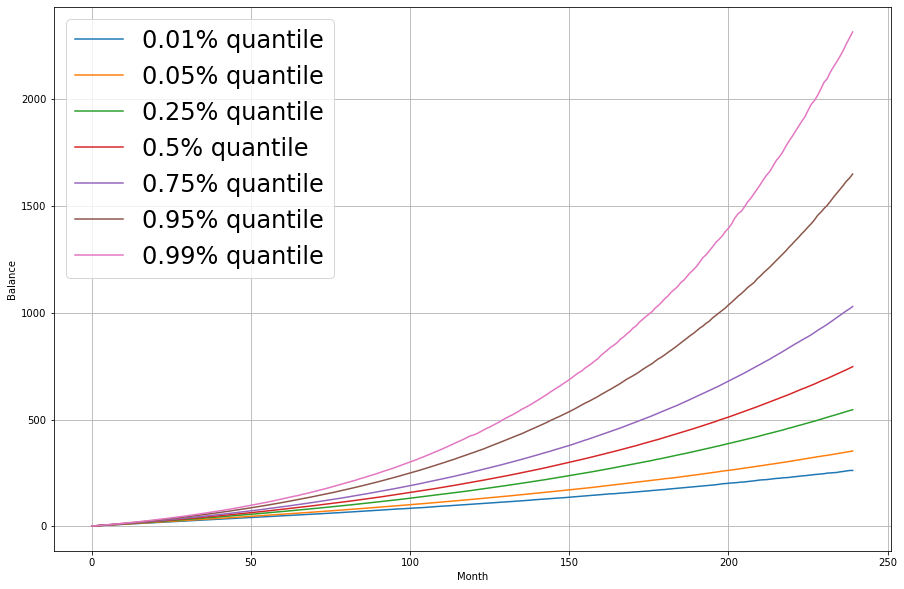

In [24]:
savings_quantiles = plot_series_aggregate(simulated_savings_df,"bootstrapped savings")

Keep in mind that those number include your investment. So off the  748 USD you have on your balance in the median case, 240 are your own capital. 